In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image

In [2]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [3]:
infd = open('rotplane.ld', 'rb')
#infd = open('ve-zone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)
data_orig = data.copy()

print(data.shape)

(11475882,)


In [4]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [5]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [6]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0

Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
    return np.where(dpeaks)[0] 
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320

#sfdata = None



In [7]:
from scipy import interpolate

# This uses numpy's interpolator, which provides very good results
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [8]:
def dumb_frameup(data, peaks, sfdata, start = 1000000):
    print(len(peaks))
    
    frame = np.zeros(525)
    framebuf = np.zeros(910 * 525, dtype=np.uint16)
    
    frameno = -1
    for i in range(0, len(peaks)):
        if peaks[i]['hsyncs'][0] < start:
            continue
        
        field = peaks[i]
        is_even = (field['gap1'] / float(field['gap2'])) < 1.05
        
        # wait until the start of a new frame
        if is_even == 0 and frameno < 0:
            frameno = 0
        
        if frameno >= 0:
            for i in range(1, len(field['hsyncs']) - 1):
                # compute line #
                l = (i - 1) * 2
                if is_even != 0:
                    l += 1
                
                linestart = field['hsyncs'][i]
                line2start = (field['hsyncs'][i + 1])
#                line2start = field['hsyncs'][i] + 1820
 
                lx = scale(data, linestart, line2start, 910)
                framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

                frame[l] = linestart
                
            if is_even == 1:
                return frame, framebuf, None

#for i in range(0,2):
#    frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
    
#drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [9]:
# set up sync color heterodyne table first 
out_fsc = 4
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))
    obhet_angles = np.angle(obhet_filt)

    level = np.amax(obhet_levels)
    phase = obhet_angles[np.argmax(obhet_levels)]
        
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

In [10]:
data = data_orig.copy()

# This filter is calibrated to bottom out at approx the middle of a regular HSYNC at about IRE -35,
# and cross over the unfiltered data at approx IRE -20.  Being analog data, this is of course a 
# bit fuzzy, especially when we hit rot.

#f_slpf_b, f_slpf_a = sps.butter(3, 400000 / freq_hz)
#f_slpf_offset = 48

f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

lpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]

synctrig = IREToRaw(-20)

#plt.plot(lpfdata[50300:51000])
#plt.plot(lpfdata[50300:51000] < synctrig)
#plt.plot(data[50300:51000])
#plt.plot(np.full(700, synctrig, dtype=np.float32))
#plt.plot(np.full(700, IREToRaw(-35), dtype=np.float32))

In [11]:
synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-60) # should only happen during rot
#sdata = np.logical_and(data < synctrig, data > rot_lowtrig)
sdata = lpfdata < synctrig

In [12]:
Ncolor = 24
sync_filter = sps.firwin(Ncolor + 1, 0.1 / (freq_mhz / 2.0), window='hamming')

def findpeaks(data):
    dinput = np.diff(data)
    dpeaks = (dinput[:-1] > 0) & (dinput[1:] < 0)
    
    return np.where(dpeaks)[0] 
    
f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [13]:
def findsyncs(data, diag=False):
    # Parameters
    synctrig = IREToRaw(-20) # this value should be below any likely colorburst for NTSC
    hslen = range(FSC * 14, FSC * 17) # typical range of horizontal syncs at synctrig level
    scanlength = int(FSC * (227.5 * 1.25)) # long enough to cover an entire line, but not long enough to see the half-line hsync as well
    
    sdata = lpfdata < synctrig
    sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
    
    peaks = findpeaks(sfdata)

    vsyncs = []
    cvsync = None
    
    if diag:
        plt.plot(sfdata[54000:57000] * 65535)
        plt.plot(data[54000:57000])
        plt.plot(lpfdata[54000:57000])
        plt.plot(np.full(3000, IREToRaw(120), dtype=np.float32))
        plt.plot(np.full(3000, IREToRaw(-45), dtype=np.float32))
        plt.plot(np.full(3000, synctrig, dtype=np.float32))
    
    # we need to detect the gaps before/after the last full vsync pulse to the prev/next regular hsync,
    # to see which kind of field we're dealing with
    previ = 0
    prevv = 0
    for i in peaks:
        if sfdata[i] > 0.5:
            if previ == None:
                return (1820 * 500), None, None
            
            if len(vsyncs) == 0 or cvsync['gap2'] is not None:
                cvsync = {'hsyncs': [], 'gap1': (i - previ), 'gap2': None}
                vsyncs.append(cvsync)
            
            prevv = i
        elif sfdata[i] > 0.25:
            if cvsync is not None:
                if cvsync['gap2'] is None:
                    cvsync['gap2'] = i - prevv
                    
                cvsync['hsyncs'].append(i)
                
            previ = i
    
    # return a few lines back before the last vsync, so the next read can start correctly
    return vsyncs[-2]['hsyncs'][-3], vsyncs, sfdata

from datetime import datetime
ts = datetime.now()
rlen, peaks, sfdata = findsyncs(data, diag = False)
print(datetime.now() - ts)

0:00:00.164417


In [59]:

def adjust_hsyncs_rough(hsyncs_orig):
    hsyncs = hsyncs_orig.copy() 
    hsd = np.diff(hsyncs)
    
    noterr = []

    for i in range(0, len(hsyncs)):
        hsync = hsyncs[i]
        
        crossp_array = np.logical_and(lpfdata[hsync:hsync + 80] < data[hsync: hsync+80], lpfdata[hsync:hsync + 80] > IREToRaw(-30))
        
        crosspoint = np.argmax(crossp_array)
        #print(i, crosspoint)
        
        hsyncs[i] -= (58 - crosspoint)
            
    return hsyncs

    

In [86]:
#rlen, peaks, sfdata = findsyncs(data)
#peaks_tmp = peaks.copy()

def get_phases(loc, line):
    line2_postcb = ((loc[1] - loc[0]) * (260/227.5)) + loc[0]
    lx = scale(data, loc[0], line2_postcb, 260 * out_fsc)
    #framebuf[l * 910:((l + 1) * 910)] = lx[0:910]

    phase1 = burst_detect(lx[32:86])[1]
    phase2 = burst_detect(lx[32+(4*227):86+(4*227)])[1]
    
    return phase1, phase2

def adjust_line(field, line, iters = 1):
    begin = field['hsyncs'][line]
    end = field['hsyncs'][line + 1]
    
    phase1, phase2 = get_phases((begin, end), line)
    # todo:  set once per field or less by averages, perhaps from a prepass?
    ptgt = np.pi if (np.fabs(phase1) > (np.pi/2)) else 0
    
    if field['ptgt'] == -1:
        field['ptgt'] = ptgt
    else:
        doinv = not (line % 2)
        ptgtbool = (field['ptgt'] == 0)
        if (doinv):
            ptgtbool = not ptgtbool
        
        if ptgtbool != (ptgt != 0):
            print("MISMATCH ", line, ptgtbool, (ptgt != 0))
        
        ptgt = np.pi if ptgtbool else 0
        
        #print(i, field['ptgt'], ptgtbool, ptgt)
        
    
    adj2 = phasemult * wrap_angle(phase2, phase1)
    end += adj2
    
    for x in range(0, iters):
        phase1, phase2 = get_phases((begin, end), line)

        adj1 = phasemult * wrap_angle(phase1, ptgt)
        begin += adj1
        adj2 = phasemult * wrap_angle(phase2, ptgt)
        end += adj2
        #print(line, x, adj1, adj2)
    
    phase1, phase2 = get_phases((begin, end), line)
    
    field['hsyncs'][line] = begin
    
    #print(line, field['hsyncs'][line], phase1, phase2)
    
def adjust_hsyncs_phase(field, iters = 1):
    field['ptgt'] = -1
    for i in range(0, len(field['hsyncs']) - 1):
        adjust_line(field, i, iters)



In [105]:
# this will probably need to be run on the host.
def adjust_hsyncs_deglitch(field):
    hsyncs = field['hsyncs']
    diffs = np.zeros_like(hsyncs)
    
    diffs[1:] = np.diff(hsyncs)
    # skip the first two and last lines, but those aren't visible anyway
    for i in range(2, len(hsyncs) - 1):
        if (np.fabs(diffs[i] - diffs[i - 1]) > 1.0) or (np.fabs(diffs[i] - (FSC * 227.5)) > 4.0):
            print(i, 'a', hsyncs[i], diffs[i], diffs[i - 1])
            #hsyncs[i] = hsyncs[i - 1] + diffs[i - 1]
            
            hsyncs[i] = hsyncs[i - 1] + ((hsyncs[i + 1] - hsyncs[i - 1]) / 2)
            
            diffs[i] = hsyncs[i] - hsyncs[i - 1]
            diffs[i + 1] = hsyncs[i + 1] - hsyncs[i]
            print(i, 'b', hsyncs[i], diffs[i], diffs[i - 1])


3
MISMATCH  45 False True
MISMATCH  130 True False
MISMATCH  182 True False
45 a 1626891.18151 1816.78670281 1819.12648493
45 b 1626894.10432 1819.70951164 1819.12648493
124 a 1770616.9116 1818.11076727 1819.34603942
124 b 1770617.87243 1819.07159004 1819.34603942
130 a 1781528.75192 1815.86894416 1818.80422636
130 b 1781532.19285 1819.30987887 1818.80422636
182 a 1876122.30555 1822.86554385 1818.86588938
182 b 1876118.47191 1819.03190411 1818.86588938
245 a 1990718.22189 1817.17454125 1819.32146197
245 b 1990720.05887 1819.01151834 1819.32146197
MISMATCH  45 False True
MISMATCH  130 True False
MISMATCH  182 True False
45 a 1626891.17622 1816.21693154 1819.69782607
45 b 1626894.41129 1819.45200074 1819.69782607
124 a 1770616.92312 1818.13791093 1819.31845363
124 b 1770617.8647 1819.07949319 1819.31845363
130 a 1781528.73515 1815.35553126 1819.30105681
130 b 1781532.44403 1819.06441333 1819.30105681
182 a 1876121.89605 1822.47847908 1818.85454498
182 b 1876118.46583 1819.04826159 1818.8

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


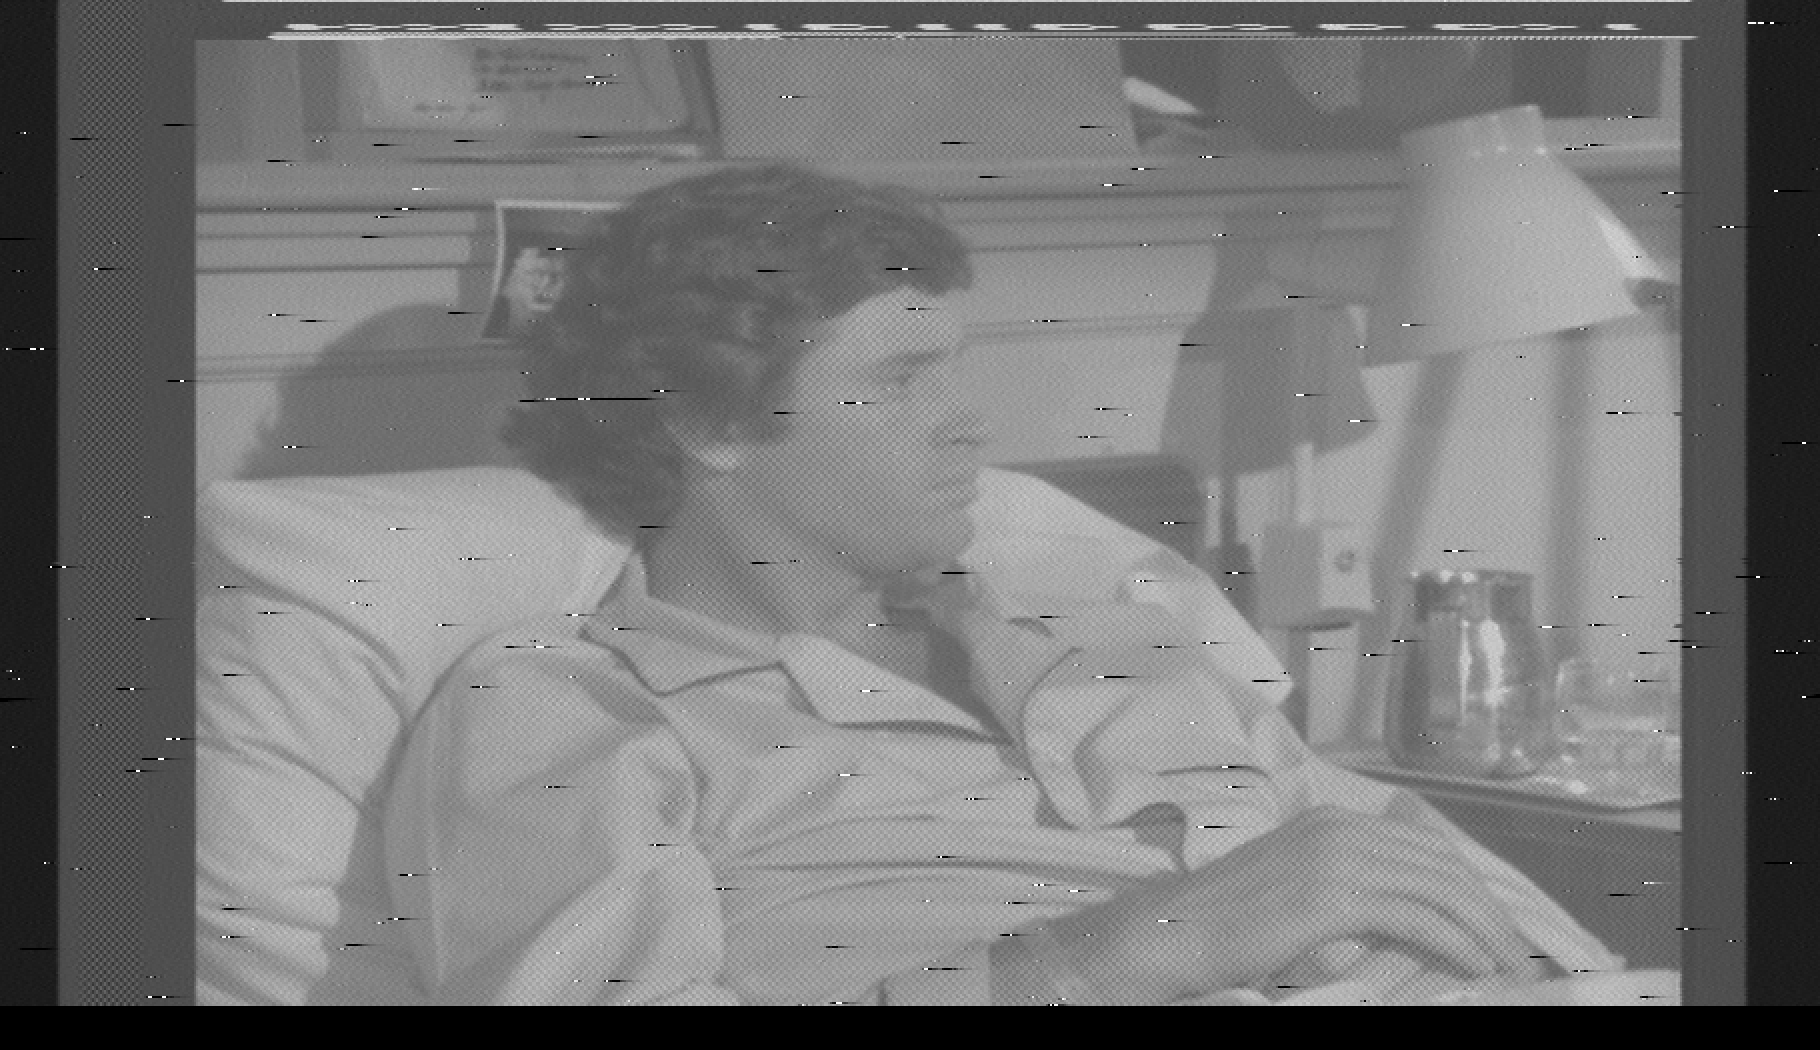

In [107]:
rlen, peaks, sfdata = findsyncs(data)
for i in range(3, 5):
    print(i)
    peaks[i]['hsyncs'] = adjust_hsyncs_rough(np.float64(peaks[i]['hsyncs']))       
    
    adjust_hsyncs_phase(peaks[i], iters=1)  
    adjust_hsyncs_deglitch(peaks[i])
    
    adjust_hsyncs_phase(peaks[i], iters=2)
    adjust_hsyncs_deglitch(peaks[i])
    
frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [57]:
sps.firwin?

In [58]:
peaks_tmp = peaks.copy()

In [ ]:
frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [ ]:
for i in range(len(peaks[3]['hsyncs']) - 1):
    adjust_line(peaks[3], i)

for i in range(len(peaks[4]['hsyncs']) - 1):
    adjust_line(peaks[4], i)
    
frame, framebuf, phases = dumb_frameup(data, peaks, sfdata)
drawdata(framebuf, x = 910, hscale = 2, vscale = 2)

In [ ]:
len(peaks[4]['hsyncs']) - 1

In [47]:
.05 * phasemult

0.06366197723675814

In [83]:
np.diff(peaks[4]['hsyncs'])

array([ 1819.00975046,  1819.38537576,  1819.35567426,  1819.26878487,
        1819.17253312,  1819.35594414,  1819.22114975,  1819.35845646,
        1819.42780309,  1819.16271738,  1819.33623573,  1819.24414986,
        1819.58372635,  1819.33381718,  1819.21316478,  1819.108521  ,
        1819.65011362,  1819.27039389,  1819.43476233,  1819.36790081,
        1819.61040112,  1819.24936402,  1819.23582242,  1819.60449019,
        1819.2017317 ,  1819.31454292,  1819.51371263,  1819.27155191,
        1819.29978498,  1819.74837665,  1819.28621474,  1819.32583536,
        1819.33717419,  1819.76390439,  1819.25938252,  1819.62080024,
        1819.45189681,  1819.4624239 ,  1819.59850145,  1819.38098813,
        1819.37390573,  1819.52052838,  1819.4486767 ,  1819.48410226,
        1819.56099968,  1819.6664015 ,  1819.31676362,  1819.5226604 ,
        1819.25913519,  1820.01464495,  1819.02680155,  1819.59398864,
        1819.43770077,  1819.80383188,  1819.36187395,  1819.48165997,
      

In [ ]:
def adjust_hsyncs_deglitch()